In [1]:
from langgraph.graph import MessagesState
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage, AnyMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
from typing import List, Dict, Any, TypedDict, Annotated
from pydantic import BaseModel
from fcgb.utils import load_txt
from fcgb.prompt_manager import PromptManager
import nest_asyncio
from fcgb.chatbots.chatbot import BaseChatBot

In [2]:
def append_or_clear(left, right):
    if right=='__clear__':
        return []
    elif right is None:
        return left
    elif left is None:
        return right
    else:
        return left + [right]

In [27]:
class SelfConversationChatBot(BaseChatBot):
    def __init__(
            self, 
            llm,
            initial_messages_spec,
            memory,
            max_turns,
            summary_spec,
            init_values={},
            prompt_manager_spec = {}
        ):

        self.summary_spec = summary_spec
        self.max_turns = max_turns
        super().__init__(
            llm=llm,
            initial_messages_spec=initial_messages_spec,
            memory=memory,
            init_values=init_values,
            prompt_manager_spec=prompt_manager_spec,
            global_inputs={'max_turns_num': self.max_turns},
            compile=False
            )

        self.summary_prompt = self.prompts.get_prompt(self.summary_spec['template'])

        self.compile_graph()

    def _set_state_class(self):

        summary_type = self.summary_spec.get('answer_format', None)

        class SelfConvState(BaseModel):
            phantom_perspective: Annotated[List[Any], append_or_clear] #MessagesState
            llm_perspective: Annotated[List[Any], append_or_clear] #MessagesState
            template_inputs: Dict[str, str]
            sub_thread_id: str | None
            parent_thread_id: str
            to_summary: bool
            turn: int
            summary: summary_type | None # type: ignore

        self.state_class = SelfConvState
        self.summary_model = summary_type

    def _set_llm_func(self):
        
        def llm_call(state: self.state_class) -> Dict: # type: ignore

            response = self.llm.invoke(state.llm_perspective)
            response.name = 'llm'
            
            return {'llm_perspective': response, 'phantom_perspective': HumanMessage(response.content, name='llm')}
        
        return llm_call
    
    def _set_phantom_func(self):
        
        def phantom_call(state: self.state_class) -> Dict: # type: ignore
            turn = state.turn
            if turn >= self.max_turns:
                outputs = {'to_summary': True}
            else:
                turn += 1
                response = self.llm.invoke(state.phantom_perspective)
                if response.content == '__end__':
                    outputs = {'to_summary': True}
                else:
                    response.name = 'phantom'
                    outputs = {'phantom_perspective': response, 'llm_perspective': HumanMessage(response.content, name='phantom')}
        
            return outputs | {'turn': turn}
        
        return phantom_call
    
    def _set_router_func(self):

        def router_func(state: self.state_class) -> Dict: # type: ignore
            if state.to_summary:
                return 'summary_node'
            else:
                return 'llm_node'
            
        return router_func
    
    def _set_summary_func(self):

        def summary_llm_call(state: self.state_class, config: RunnableConfig) -> Dict: # type: ignore
            summary_task = HumanMessage(self.summary_prompt.format(**state.template_inputs, **self.global_inputs))
            response = self.llm.with_structured_output(self.summary_model).invoke(state.phantom_perspective + [summary_task])

            sub_thread_id = config['configurable']['thread_id']
            return {'summary': response, 'sub_thread_id': sub_thread_id, 'to_summary': False}
        
        return summary_llm_call

    
    def _compile_graph(self):

        phantom_func = self._set_phantom_func()
        llm_func = self._set_llm_func()
        router_func = self._set_router_func()
        summary_llm_call_func = self._set_summary_func()

        workflow = StateGraph(self.state_class)
        workflow.add_node('phantom_node', phantom_func)
        workflow.add_node('llm_node', llm_func)
        workflow.add_node('summary_node', summary_llm_call_func)

        workflow.add_edge(START, 'phantom_node')
        workflow.add_conditional_edges('phantom_node', router_func, ['summary_node', 'llm_node'])
        workflow.add_edge('llm_node', 'phantom_node')
        workflow.add_edge('summary_node', END)

        self.graph = workflow.compile(
            checkpointer=self.memory
        )
    
    def run(self, task: str, context: str, sub_thread_id: str, parent_thread_id: str):

        template_inputs = {'task': task, 'context': context}
        self.init_thread(sub_thread_id, template_inputs=template_inputs)

        config = self._get_config(sub_thread_id)

        return self.graph.invoke({'parent_thread_id': parent_thread_id, 'template_inputs': template_inputs}, config=config)

In [28]:
from fcgb.fake_models import FakeLLM
from fcgb.cfg.chat_inputs_spec import SelfConversationConfig

fake_llm = FakeLLM()
memory = MemorySaver()

chatbot = SelfConversationChatBot(
    llm=fake_llm,
    initial_messages_spec=SelfConversationConfig.initial_messages_spec,
    memory=memory,
    max_turns=3,
    summary_spec=SelfConversationConfig.summary_spec,
    init_values=SelfConversationConfig.init_values
)

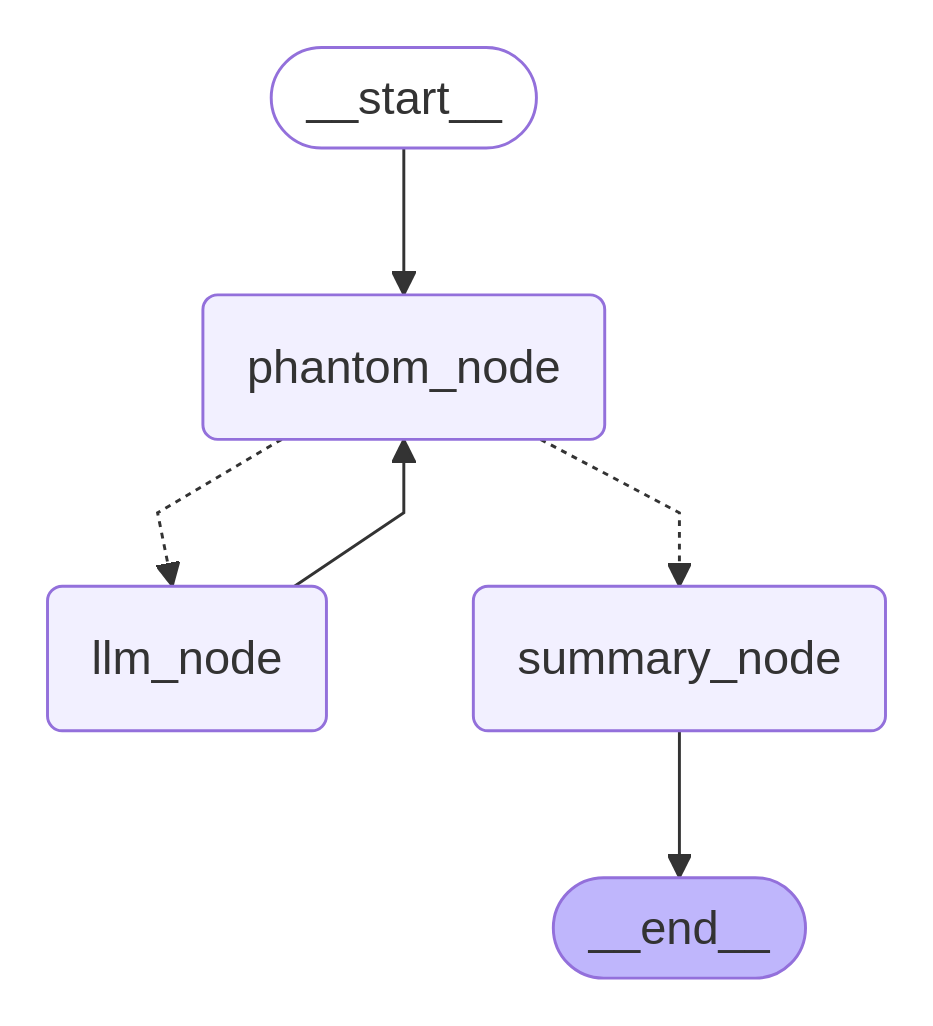

In [31]:
chatbot.display_graph()

In [29]:
inputs = {
    'task': 'List all variants of Chain-of-Thought (CoT) prompting.',
    'context': 'You want to prepare a full list of different CoT prompting methods for further research.',
    'sub_thread_id': 'test_1/sc1',
    'parent_thread_id': 'test_1'
}

result = chatbot.run(**inputs)
result

{'phantom_perspective': [SystemMessage(content="Your mission is to by a conversation with some field expert extract information to accomplish your task with a given context.\nYou have maximum of 3 question-answer turns to reach your goal, but you can call the conversation end sign earlier.\nBe persistent to extract as many information as you can to fulfill your task. Ask questions from different angles.\nYou can also argue with the expert when you will feel that their answers are not satisfying. Try different techniques to fully cover your task.\nUse provided context to better direct your questions.\nwhen you feel that you gain necessary information just type '__end__' instead of next question. \n-----\nTASK: \nList all variants of Chain-of-Thought (CoT) prompting.\n-----\nCONTEXT: \nYou want to prepare a full list of different CoT prompting methods for further research.\n-----\nTo finish conversation type: __end__", additional_kwargs={}, response_metadata={}, name='basic'),
  HumanMes

In [30]:
chatbot.get_state('test_1/sc1')

{'to_summary': False,
 'turn': 3,
 'summary': SelfConvModel(answer='Fake string qfhem'),
 'sub_thread_id': 'test_1/sc1',
 'phantom_perspective': [SystemMessage(content="Your mission is to by a conversation with some field expert extract information to accomplish your task with a given context.\nYou have maximum of 3 question-answer turns to reach your goal, but you can call the conversation end sign earlier.\nBe persistent to extract as many information as you can to fulfill your task. Ask questions from different angles.\nYou can also argue with the expert when you will feel that their answers are not satisfying. Try different techniques to fully cover your task.\nUse provided context to better direct your questions.\nwhen you feel that you gain necessary information just type '__end__' instead of next question. \n-----\nTASK: \nList all variants of Chain-of-Thought (CoT) prompting.\n-----\nCONTEXT: \nYou want to prepare a full list of different CoT prompting methods for further resea

In [32]:
from fcgb.rag.precompiled import get_llm

llm = get_llm('google')

In [49]:
memory = MemorySaver()

chatbot = SelfConversationChatBot(
    llm=llm,
    initial_messages_spec=SelfConversationConfig.initial_messages_spec,
    memory=memory,
    max_turns=6,
    summary_spec=SelfConversationConfig.summary_spec,
    init_values=SelfConversationConfig.init_values
)

In [50]:
inputs = {
    'task': 'List all variants of Chain-of-Thought (CoT) prompting.',
    'context': 'You want to prepare a full list of different CoT prompting methods for further research. More is better!',
    'sub_thread_id': 'test_1/sc1',
    'parent_thread_id': 'test_1'
}

result = chatbot.run(**inputs)

In [51]:
for line in result['summary'].answer.split('\n'):
    print(line)

Here's a comprehensive list of Chain-of-Thought (CoT) prompting variants:

*   Standard CoT
*   Zero-shot CoT
*   Self-Consistency
*   Least-to-Most prompting
*   Tree-of-Thoughts (ToT)
*   Graph of Thoughts (GoT)
*   Program-of-Thoughts (PoT)
*   Faithful Chain-of-Thought (Faithful CoT)
*   Complexity-Based CoT
*   Knowledge-augmented CoT
*   Verification-based CoT
*   Adaptive CoT
*   Template-based CoT


In [54]:
for msg in result['phantom_perspective']:
    msg.pretty_print()

================================ System Message ================================
Name: basic

Your mission is to by a conversation with some field expert extract information to accomplish your task with a given context.
You have maximum of 6 question-answer turns to reach your goal, but you can call the conversation end sign earlier.
Be persistent to extract as many information as you can to fulfill your task. Ask questions from different angles.
You can also argue with the expert when you will feel that their answers are not satisfying. Try different techniques to fully cover your task.
Use provided context to better direct your questions.
when you feel that you gain necessary information just type '__end__' instead of next question. 
-----
TASK: 
List all variants of Chain-of-Thought (CoT) prompting.
-----
CONTEXT: 
You want to prepare a full list of different CoT prompting methods for further research. More is better!
-----
To finish conversation type: __end__
======================

# Experiments

In [23]:
from fcgb.fake_models import FakeLLM, FakeHuman

fake_llm = FakeLLM()
fake_human = FakeHuman(button_output='Some button output', button_moment=None)

In [5]:
class TestBaseChatTemplateInputs(TypedDict, total=False):
    sys_temp_1: str
    ai_temp_1: str
    hum_temp_1: str

In [ ]:
initial_messages_spec = [
            {"source": "system", "template": "base_chat_system", "hidden": False},
            {"source": "ai", "template": "base_chat_init_ai", "hidden": False},
            {"source": "human", "template": "base_chat_init_human", "hidden": True, "as_node": "human_node"},
        ]

template_inputs = {
    'sys_temp_1': 'system_input_1',
    'ai_temp_1': 'ai_input_1',
    'hum_temp_1': 'human_input_1'
}


In [ ]:
from datetime import datetime


'2025-05-19 14:24:04'

In [191]:
from langchain_core.runnables.config import RunnableConfig
from langgraph.constants import Send
from typing import List, Dict, Any, TypedDict, Annotated
from operator import add

class SubState(TypedDict):
    question: str
    messages: List[Dict[str, Any]]
    summary: str
    sub_thread_id: str
    parent_thread_id: str

class MainState(TypedDict):
    questions: List[str]
    summary: Annotated[List[str], add]
    sub_thread_id: Annotated[List[Any], add]

def conversation_node(state: SubState, config: RunnableConfig):
    print('conv node', state['question'])
    print('conv state', state)
    messages = state.get("messages", []) + [{"role": "user", "content": "..."}] + [{"role": "assistant", "content": "..."}]
    return {"messages": messages}

def summarize_node(state: SubState, config: RunnableConfig):
    summary = "summary for: " + state.get("question", "")
    print('summarize_node', summary)
    return {"summary": summary, "sub_thread_id": config["configurable"]["thread_id"]}

memory = MemorySaver()

subgraph = StateGraph(SubState) # Give the subgraph a name
subgraph.add_node("conversation", conversation_node)
subgraph.add_node("summarize", summarize_node)
subgraph.set_entry_point("conversation")
subgraph.add_edge("conversation", "summarize")
subgraph.add_edge("summarize", END)
compiled_subgraph = subgraph.compile(checkpointer=memory, name="subgraph")

def init_node(state: MainState, config: RunnableConfig):
    questions = ["question 1", "question 2", "question 3"]
    return {"questions": questions}

def routing_edge(state: MainState, config: RunnableConfig):
    thread_id = config['configurable']['thread_id']
    past_turns = len(state['summary'])
    print('routing_edge', state)
    return [Send('conv', {'question': question, 'sub_thread_id': f'{thread_id}/{i+past_turns}', 'parent_thread_id': thread_id}) for i,question in enumerate(state["questions"])]

def subgraph_node(state: SubState, config: RunnableConfig):
    response = compiled_subgraph.invoke(state, config={'configurable': {'thread_id': state['sub_thread_id']}})
    print('subgraph_node', response)
    return {'summary': [response['summary']], 'sub_thread_id': [response['sub_thread_id']]}

def output_node(state: MainState, config: RunnableConfig):
    print('output_node', state)
    return {}

maingraph = StateGraph(MainState)
maingraph.add_node("init", init_node)
maingraph.add_node("conv", subgraph_node)
maingraph.add_node("output", output_node)

maingraph.set_entry_point("init")
maingraph.add_conditional_edges("init", routing_edge, ["conv"])
maingraph.add_edge("conv", "output")
maingraph.set_finish_point("output")
compiled_maingraph = maingraph.compile(checkpointer=memory, name="maingraph")


In [195]:
config = {'configurable': {'thread_id': 'test1/3'}}
compiled_subgraph.invoke({'question': "What is the meaning of life?"}, config=config)

conv node What is the meaning of life?
conv state {'question': 'What is the meaning of life?', 'messages': [{'role': 'user', 'content': '...'}, {'role': 'assistant', 'content': '...'}], 'summary': 'summary for: question 1', 'sub_thread_id': 'test1/3', 'parent_thread_id': 'test1'}
summarize_node summary for: What is the meaning of life?


{'question': 'What is the meaning of life?',
 'messages': [{'role': 'user', 'content': '...'},
  {'role': 'assistant', 'content': '...'},
  {'role': 'user', 'content': '...'},
  {'role': 'assistant', 'content': '...'}],
 'summary': 'summary for: What is the meaning of life?',
 'sub_thread_id': 'test1/3',
 'parent_thread_id': 'test1'}

In [193]:
config = {'configurable': {'thread_id': 'test1'}}
compiled_maingraph.invoke({'summaries': [], 'threads': []}, config=config)

routing_edge {'questions': ['question 1', 'question 2', 'question 3'], 'summary': ['summary for: question 1', 'summary for: question 2', 'summary for: question 3'], 'sub_thread_id': ['test1/0', 'test1/1', 'test1/2']}
conv node question 1
conv state {'question': 'question 1', 'sub_thread_id': 'test1/3', 'parent_thread_id': 'test1'}
conv node question 2
conv state {'question': 'question 2', 'sub_thread_id': 'test1/4', 'parent_thread_id': 'test1'}
conv node question 3
conv state {'question': 'question 3', 'sub_thread_id': 'test1/5', 'parent_thread_id': 'test1'}
summarize_node summary for: question 1
summarize_node summary for: question 2
summarize_node summary for: question 3
subgraph_node {'question': 'question 1', 'messages': [{'role': 'user', 'content': '...'}, {'role': 'assistant', 'content': '...'}], 'summary': 'summary for: question 1', 'sub_thread_id': 'test1/3', 'parent_thread_id': 'test1'}
subgraph_node {'question': 'question 2', 'messages': [{'role': 'user', 'content': '...'}, {

{'questions': ['question 1', 'question 2', 'question 3'],
 'summary': ['summary for: question 1',
  'summary for: question 2',
  'summary for: question 3',
  'summary for: question 1',
  'summary for: question 2',
  'summary for: question 3'],
 'sub_thread_id': ['test1/0',
  'test1/1',
  'test1/2',
  'test1/3',
  'test1/4',
  'test1/5']}

In [194]:
memory.get({'configurable': {'thread_id': 'test1/3'}})

{'v': 3,
 'ts': '2025-05-19T12:59:08.091816+00:00',
 'id': '1f034b10-d073-6932-8002-01716646f215',
 'channel_versions': {'__start__': '00000000000000000000000000000002.0.09870959791305467',
  'question': '00000000000000000000000000000002.0.23559829325603876',
  'sub_thread_id': '00000000000000000000000000000004.0.21746122845995886',
  'parent_thread_id': '00000000000000000000000000000002.0.473865111175267',
  'branch:to:conversation': '00000000000000000000000000000003.0.8975372832302293',
  'messages': '00000000000000000000000000000003.0.8872705994398674',
  'branch:to:summarize': '00000000000000000000000000000004.0.49317071265445367',
  'summary': '00000000000000000000000000000004.0.5372675794601917'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000001.0.7129236985518004'},
  'conversation': {'branch:to:conversation': '00000000000000000000000000000002.0.048758464188705886'},
  'summarize': {'branch:to:summarize': '00000000000000000000000

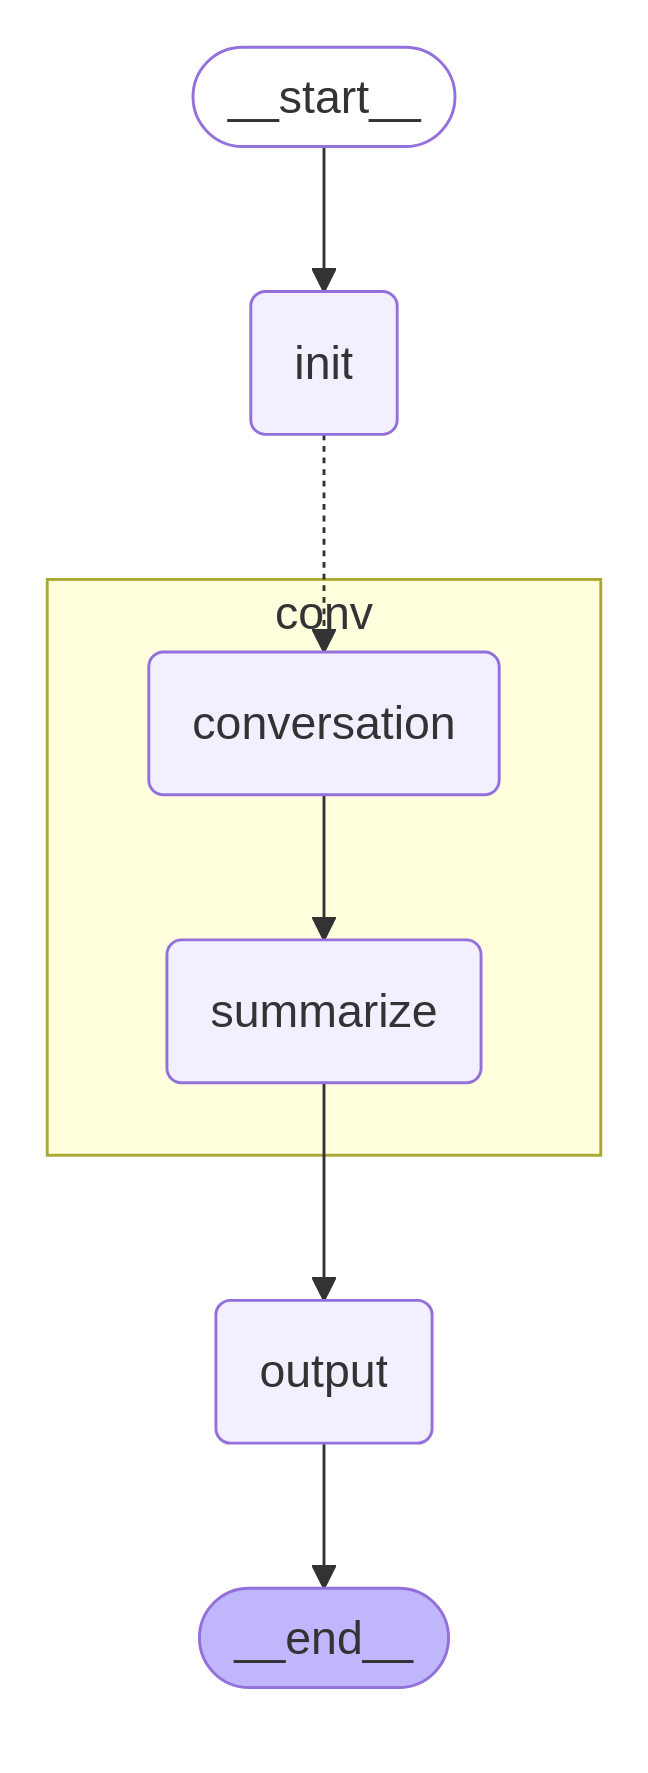

In [32]:
nest_asyncio.apply()
display(Image(compiled_maingraph.get_graph(xray=1).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER), height=200, width=200))